In [1]:
%matplotlib inline

import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil

In [2]:
TRAIN_PATH = 'data/Train/'
TEST_PATH = 'data/Test/'
VALIDATION_PATH = 'data/Validation/'

### Dataset Sizes

In [95]:
def set_size_summary(base_dir, subsets=['']):
    num_images = 0
    imgs_paths = []
    for class_folder in os.listdir(base_dir):
        for subset in subsets:
            if subset:
                imgs_paths.extend(glob.glob(f'{base_dir}{class_folder}/{subset}/*.ppm'))
            else:
                imgs_paths.extend(glob.glob(f'{base_dir}{class_folder}/*.ppm'))        
            imgs_count = len(imgs_paths)
            num_images += imgs_count
            print(f'{imgs_count} images of class {class_folder}.')
    print(f'\nTotal number of images: {num_images}')

In [96]:
def plot_sample_paths(base_dir):
    paths = glob.glob(f'{base_dir}/**/*.ppm', recursive=True)
    samples = np.random.choice(paths, 3, replace=False)
    fig=plt.figure(figsize=(10, 10))
    for n, sample in enumerate(samples, 1):
        fig.add_subplot(1, 3, n)
        img = plt.imread(sample)
        plt.imshow(img)
    plt.show();

- Training Set

Checking training set class distribution:

In [97]:
!ls {TRAIN_PATH}

A  B  C  Five  Point  V


In [98]:
set_size_summary(TRAIN_PATH)

458 images of class C.
1522 images of class A.
2638 images of class Point.
3162 images of class Five.
3510 images of class V.
3900 images of class B.

Total number of images: 15190


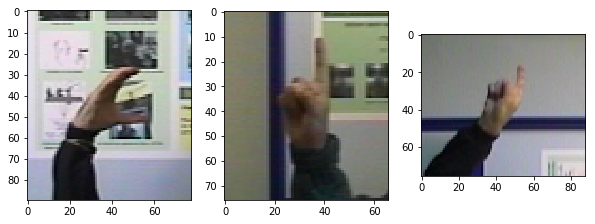

In [99]:
plot_sample_paths(TRAIN_PATH)

- Test Set

And also our test set distribution:

In [100]:
!ls {TEST_PATH}

A  B  C  Five  Point  V


In [101]:
for class_folder in os.listdir(TEST_PATH):
    imgs_paths = glob.glob(f'{TEST_PATH}{class_folder}/complex/*.ppm')
    imgs_paths.extend(glob.glob(f'{TEST_PATH}{class_folder}/uniform/*.ppm'))
    imgs_count = len(imgs_paths)
    print(f'{imgs_count} images of class {class_folder}.')

112 images of class C.
97 images of class A.
119 images of class Point.
134 images of class Five.
95 images of class V.
102 images of class B.


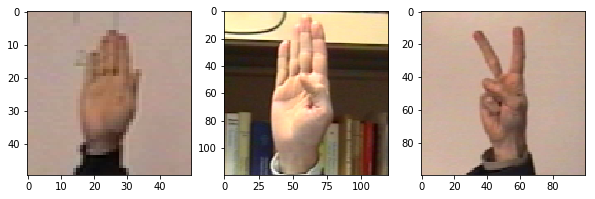

In [102]:
plot_sample_paths(TEST_PATH)

### Create Validation Set

Creating a validation set from training set:

In [106]:
for class_folder in os.listdir(TRAIN_PATH):
    imgs_paths = glob.glob(f'{TRAIN_PATH}{class_folder}/*.ppm')
    np.random.shuffle(imgs_paths)
    if not os.path.exists(f'{VALIDATION_PATH}'):
        os.mkdir(f'{VALIDATION_PATH}')
    if not os.path.exists(f'{VALIDATION_PATH}{class_folder}/'):
        os.mkdir(f'{VALIDATION_PATH}{class_folder}/')
    for image_path in imgs_paths[:int(len(imgs_paths)*0.2)]:
        shutil.move(image_path, os.path.join(f'{VALIDATION_PATH}{class_folder}', os.path.basename(image_path)))

In [107]:
set_size_summary(TRAIN_PATH)

367 images of class C.
1219 images of class A.
2112 images of class Point.
2532 images of class Five.
2811 images of class V.
3123 images of class B.

Total number of images: 12164


In [108]:
set_size_summary(VALIDATION_PATH)

205 images of class C.
682 images of class A.
1184 images of class Point.
1418 images of class Five.
1574 images of class V.
1749 images of class B.

Total number of images: 6812
